To DO

+ ~~change landing page~~
+ ~~DONE add loading options to simulation; must explore useAsyncQueue NOPE (AsyncQueue too different from AsyncState)~~
+ ~~DONE add table; use icons for table segments; need to have column groups~~
+ ~~DONE!   need to add charts~~

+ ~~localstorage for chart values~~
+ ~~add env statement~~
+ ~~improve Chart aesthetics~~
    ~~+ window or tiles or windows with tiles~~
    ~~+ stack legend~~
    ~~+ use theme-related colors~~
    ~~+ pass appropriate x- and y-label values~~
+ ~~standardize container sizes and alignments~~
+ ~~improve Table aesthetics~~
    + ~~add units for rows in Summary~~
+ ~~use Celery and Redis for async tasks to save monthly / quarterly / annual versions of statements~~
+ ~~added celery autoreload
+ ~~MAKE NOTE THAT CHARTS ARE MONTHLY!!!!~~
+ ~~check all math~~
    + ~~why is block schedule wrong?~~
        + ~~had placeholder for current block~
    + ~~number of miners???~~
    + ~~cost of miners~~
    + ~~Why do roi and istat not overlap in terms of number of periods??????~~
    + ~~no pool fees?~~
+ ~~check if statement object exist, if so, get monthly and summary only; should be much faster~~
+ ~~add current BTC environment modal~~
    + ~~feed-in live environment to enviroment assumptions~~
+ ~~no scaling done for Heat rejection products????~~
+ ~~improve aesthetics of environment section~~
    + ~~improve chart layout~~
    + ~~improve summary layout~~
+ ~~enviro aesthetics~~
    + ~~transaction fees y-axis range needs fixing~~
    + ~~enviro select load ... no user feedback~~
+ major Simulation Improvements
    + add temperature impacts
        + currently using Student's T to simulate temps but need to clip at .25% and 99.5% to eliminate extreme values;
        + see products/serializers line 259/260 in DryBulbSimulationSerializer
        + is there a better distribution? faster way to do all stations?
        + need to use time-series ....
    + add opex projection module
    + need to add curtailment / switching on-off of miners
    + need to feed in variable chip temp
    + need to account for delta T at higher overclocking
    + additional metrics:
        + compare to BTC HODL strategy
        + percentage revenue from appreciation vs. fees
        + hash share should be percentage of actual hash rate, not difficulty
+ aesthetic / input imporvements
    + allow manual scaling and pricing of products
    + need full statements and charts for each project
    + fix Epoch alignmnet for block schedule
    + ~~flag form changes for save~~
    + ~~input title at top~~
    + ~~improve infra section and remove errors~~
    + ~~ProjectSim CRUD at point of sale ... need to clean up combobox interaction~~
+ additional Module improvements
    + price updates for miners
    + add Bitcoin mining demo
    + improve infra product database

+ drillbit improvements
    + time unit not working as expected

+ code efficiency 
    + push M/Q/A statement creation INTO the serializer so that finstat resample can be used; how to get task_ids ?????
    + need better atomicity of database transactions

+ push live to google
+ testing for drillbit
+ testing for drillbit-vj
+ testing for drillbit-dj
+ updates to finstat

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import django
os.environ.setdefault('DJANGO_SETTINGS_MODULE', 'drillbit_dj.settings')
os.environ["DJANGO_ALLOW_ASYNC_UNSAFE"] = "true"
django.setup()

In [3]:
import numpy as np
import pandas as pd

In [4]:
from drillbit import BitcoinEnvironmentUtility
from drillbit.__new_objects import Rig as RigManager, Product as ProductManager, \
    Cooling as CoolingManager, Project as ProjectManager, \
    OverClock, RigOperator
from drillbit.__new_units__ import AbstractBaseUnit, MagnitudeTable, Hashes, HashRate, \
    Time, Power, Energy, Efficiency, EnergyPrice


from environment.serializers import EnvironmentSerializer as EnviroSer, BlockScheduleSerializer as BSchedSer, \
    BitcoinPriceSerializer as BPSer, TransactionFeesSerializer as FeeSer, HashRateSerializer as HRSer
from environment.models import Environment, BlockSchedule, BitcoinPrice, TransactionFees, HashRate as HashRateModel

from products.models import Rig, Cooling, HeatRejection, Electrical, RejectionCurve
from products.serializers import RigSerializer, CoolingSerializer, HeatRejectionSerializer, \
    ElectricalSerializer, RejectionCurveForProductSerializer as CurveSerializer

from projects.models import RigForProject, InfraForProject, Project, Projects, \
    ProjectStatement, ProjectSimulation, ProjectStatementSummary
from projects.serializers import RigForProjectSerializer, InfraForProjectSerializer, ProjectSerializer, ProjectsSerializer, \
    ProjectScalingSerializer, ProjectCostsSerializer, ProjectStatementSerializer, \
    ProjectStatementSummarySerializer, fit_temperature_to_environment

from projects.tasks import create_statements_for_given_project, create_statement_for_given_frequency

In [5]:
import numpy as np
from tqdm.auto import tqdm, trange
import pandas as pd
import numpy_financial as npf

import finstat as fs

from drillbit.statements.funcs import total_energy, win_percentage, \
    expected_difficulty, hashes_to_hash_rate, win_percentage
from drillbit.statements.statements import ProjectTemplate

from products.models import WeatherStation, WeatherData
from products.serializers import expected_loss_from_insufficient_cooling_capacity, \
    RejectionTemperatureImpactSerializer as RejTempSer, \
    RejectionTemperaturePaybackSerializer as RejPayBackSer, \
    DryBulbSimulationSerializer as DBSimSer

In [6]:
from drillbit.statements.statements import init_environment, ProjectTemplate, ROITemplate, \
    analysis

In [7]:
# OVERCLOCKING STRATEGY: increase overclocking during maintenance periods ???

# Immediate Goals
# Feed temperature data through vj into dj
# Adjust financial statements to provide max capacity at each stage
# adjust project form to allow for manual pricing (?and scaling???)

# prefer that Project does NOT know anything about the environment
# so Project needs ability to manipulate time-series data so that it fits 
# the environment

# so, ambient_temp will accept a time-series, either that is a single year annually, 
# which it will manipulate to fit the environment, OR a time-series will be provided
# that fits the assumed environment ... BUT this MUST require the temp
# fits the environment
# for the serializer, if a station_id is saved, we know to store ambient temp as 
# single-year annually, that will be manipulated using standard formula

In [8]:
projects = Projects.objects.get(pk=9)

In [9]:
project = Project.objects.get(pk=99)
env = Environment.objects.latest('created_at')

sim = ProjectSimulation.objects.create(environment=env, project=project)

In [10]:
blocks = BSchedSer(
    sim.environment.block_schedule, 
).to_schedule(with_period_index=True)
price = BPSer(
    sim.environment.bitcoin_price, 
).to_schedule()
fees = FeeSer(
    sim.environment.transaction_fees,
).to_schedule()
hash_rate = HRSer(
    sim.environment.hash_rate, 
).to_schedule()

env = init_environment(
    blocks,
    price.forecast,
    fees.forecast,
    hash_rate.forecast * 1e6 * 1e12 # convert from M TH/s to H/s
    #// hack to handle network hash rate b/c number is too big for calculation; see FactorForm line 55 for offsetting hack in frontend
)

In [11]:
temp = fit_temperature_to_environment(sim.project.target_ambient_temp, blocks)

In [12]:
proj = sim.project.as_drillbit_object(temp)

In [17]:
proj.implement()

In [18]:
stat = ProjectTemplate(env, proj)

In [35]:
temp = DBSimSer(data={'station': station.id})
temp.is_valid()
temp = temp.save()

In [31]:
temp = pd.Series(temp['data'], index=pd.PeriodIndex(temp['periods'], freq='H'))
temp = temp.resample('10T').ffill()

n_leap_years = pd.period_range(start=blocks.index[0], end=blocks.index[-1], freq='A').is_leap_year.sum()
n_years = blocks.index[-1].year - temp.index[-1].year + 1
full_temp = pd.concat([temp]*n_years)

if n_leap_years:
#     hack to handle leap_years
    full_temp = pd.concat((full_temp, full_temp.iloc[-n_leap_years*24*6:]))

full_temp.index = pd.period_range(start=full_temp.index[0], freq='10T', periods=full_temp.size)
missing = blocks.shape[0] - full_temp.loc[blocks.index[0]: blocks.index[-1]].shape[0]
end = blocks.index.shift(missing)[-1] if missing > 0 else blocks.index[-1]

full_temp = full_temp.loc[blocks.index[0]:end]
full_temp = full_temp.to_frame()
full_temp.columns = ['Temp']
full_temp.Temp.tolist()

In [12]:
project = project.as_drillbit_object()
project.target_ambient_temp = 

In [14]:
scaler = project._get_scaler()
project.rigs.schedule = project.capacity_schedule() / scaler.total_power_per_rig()

In [20]:
stat = ProjectTemplate(env, project)


In [8]:
btc = BitcoinEnvironmentUtility()
environment = Environment.objects.latest('created_at')
project = Project.objects.latest('created_at')

In [200]:
temps_by_month = []
for m in trange(temps.shape[0]):
    month = pd.Period(freq='M', month=m+1, year=2022)
    temps_by_hr = np.zeros((24, month.days_in_month))
    for hr, mean_temp in np.ndenumerate(temps[m, :, 0]):
        norm = scist.norm(mean_temp, optimal_vars[m, hr])
        temps_by_hr[hr] = norm.rvs(month.days_in_month)
    
    temps_by_month += np.transpose(temps_by_hr).flatten().tolist() # transpose swaps the dimensions

periods = pd.period_range(periods=len(temps_by_month), freq='H', end=month)

100%|███████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 66.47it/s]


In [201]:
ser = pd.Series(temps_by_month, index=periods)

In [58]:
actual = WeatherData.objects.get(
    station=station,
    type='single-variable frequency',
    variable='Dry-Bulb'
)

<AxesSubplot:xlabel='Dry-Bulb °F', ylabel='Frequency'>

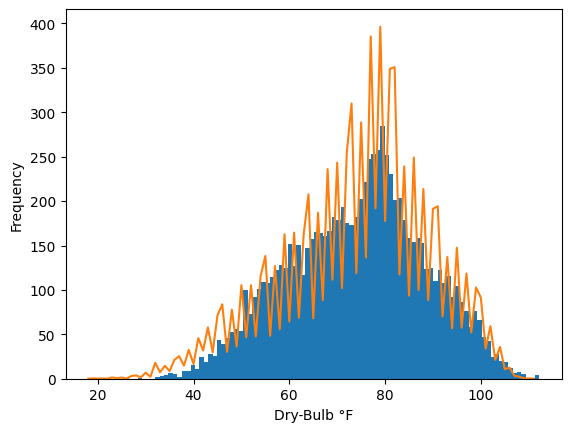

In [104]:
ser.plot.hist(bins=94)
pd.DataFrame(actual.data).set_index('Dry-Bulb °F').iloc[:, 0].plot()

In [7]:
import itertools as it

In [17]:
import scipy.stats as scist
import time

def estimate_parameters(diurnal_key, station_id):
    datas = diurnal_key[station_id]
    dfs = []
    months = []
    for data in datas:
        df = pd.DataFrame(data['data']) \
            .set_index('Hour')
        month = pd.Period(data['period'], freq='M', year=2022)
        months.append(month)
        dfs.append(df)

    df = pd.concat(dfs, keys=months, names=['Month', 'Hour']).sort_index()
    temps = df.values.reshape(-1, 24, 6)

    q = [.1, .25, .5, .75, .9]
    degs_of_f = np.arange(1,30)
    variances = np.arange(2,12,.5)
    params = list(it.product(degs_of_f, variances))
    estimates = np.zeros((len(params), *temps.shape[:2], len(q)))
    for i in range(len(params)):
        df, var = params[i]
        for (j, k), mean_temp in np.ndenumerate(temps[:, :, 0]):
            estimates[i, j, k] = scist.t(df, loc=mean_temp, scale=var).ppf(q)

    errors = temps[:, :, 1:] - estimates
    sq_errs = errors**2
    std_errs = sq_errs.sum(axis=3) / len(q)
    idx_of_optimal_params = std_errs.argmin(axis=0)

    params_est = np.zeros_like(idx_of_optimal_params, dtype=object)
    for (m, hr), val in np.ndenumerate(idx_of_optimal_params):
        df, var = params[val]
        params_est[m,hr] = float(df), float(var)

    return station_id, params_est

In [15]:
all_diurnal = WeatherData.objects.filter(
    type='diurnal',
    variable='Dry-Bulb'
)

diurnal_key = {}
for diurnal in all_diurnal:
    if diurnal.station_id not in diurnal_key:
        diurnal_key[diurnal.station_id] = [{'period': diurnal.period, 'data': diurnal.data}]
    else:
        diurnal_key[diurnal.station_id].append({'period': diurnal.period, 'data': diurnal.data})

stations = WeatherStation.objects.filter(region='Texas')
has_stations = WeatherData.objects.filter(
    type='month-hour-params-students-t',
    variable='Dry-Bulb',
).values_list('station', flat=True)
stations = stations.exclude(id__in=has_stations)
station_ids = stations.values_list('id', flat=True)

results = {}
for station_id in tqdm(station_ids):
    station_id, params_est = estimate_parameters(diurnal_key, station_id)
    results[station_id] = params_est.tolist()

for station_id, params_est in results.items():
    station = stations.get(id=station_id)
    weather_data = WeatherData(
        station=station,
        type='month-hour-params-students-t',
        variable='Dry-Bulb',
        data=params_est
    )
    weather_data.save()

In [88]:
df = 4
mean_temp = 75
var = 9

In [90]:
import scipy.stats as scist

In [94]:
norm = scist.t(df, loc=mean_temp, scale=var)
rvs = norm.rvs(30)

In [100]:
norm.ppf([0.0025, 0.995])

array([ 24.62188469, 116.43685384])

array([ 88.01249057,  67.53285535,  70.74067214,  79.93232119,
        64.95353589,  62.45734848,  87.72293399,  81.74960279,
        47.58458606,  24.62188469,  64.86760818,  74.30689064,
        78.55032498,  80.51029084, 116.42144919,  81.71617232,
        76.1748829 ,  79.53760029,  81.89151249,  73.3039353 ,
        70.81294092,  64.14755857,  65.35023019,  63.99948148,
        65.27300345,  62.98886067, 116.43685384,  80.73023839,
        68.4191076 ,  53.24843369])

In [52]:
temps_by_month = []
for m in trange(temps.shape[0]):
    month = pd.Period(freq='M', month=m+1, year=2022)
    temps_by_hr = np.zeros((24, month.days_in_month))
    for (hr,), mean_temp in np.ndenumerate(temps[m, :, 0]):
        df, var = temp_params[m, hr]
        mean_temp = temps[m, hr, 0]
        norm = scist.t(df, loc=mean_temp, scale=var)
        temps_by_hr[hr] = norm.rvs(month.days_in_month)
    
    temps_by_month += np.transpose(temps_by_hr).flatten().tolist() # transpose swaps the dimensions

periods = pd.period_range(periods=len(temps_by_month), freq='H', end=month)

  0%|          | 0/12 [00:00<?, ?it/s]

In [105]:
ser1 = pd.Series(temps_by_month, index=periods)

In [27]:
ser1.periods

NameError: name 'ser1' is not defined

In [108]:
ser1.to_list()

[73.35105095987183,
 48.4989014844122,
 44.08048955152924,
 41.92489714413581,
 52.27875079940244,
 38.08746857258835,
 45.074004318964285,
 64.71579375703003,
 53.904981708205746,
 55.660659447616965,
 72.34799981570826,
 77.32765982365092,
 70.27239999845295,
 60.96162649941434,
 75.67179440653521,
 64.34334557985336,
 91.04328295771448,
 55.096547438376334,
 49.3100596725664,
 62.23843381537703,
 45.67088493196629,
 50.986891072926916,
 53.12520045080941,
 33.82425310407799,
 63.393459969952005,
 51.932479291752,
 46.06259487889009,
 44.84419017258788,
 29.15875385265265,
 71.53347080801092,
 42.453839151656325,
 57.584869311773595,
 68.5989005180376,
 51.19181022341474,
 74.15554872056144,
 63.08975466327346,
 57.07993935239172,
 37.331898529720576,
 66.52748982444692,
 71.25603526884278,
 66.9525582172902,
 76.15772952181952,
 72.63671986964017,
 52.50267836686897,
 54.22310737729417,
 57.89799056325717,
 52.258275955561274,
 54.373685140286554,
 56.9421709041945,
 53.672671016591

<AxesSubplot:>

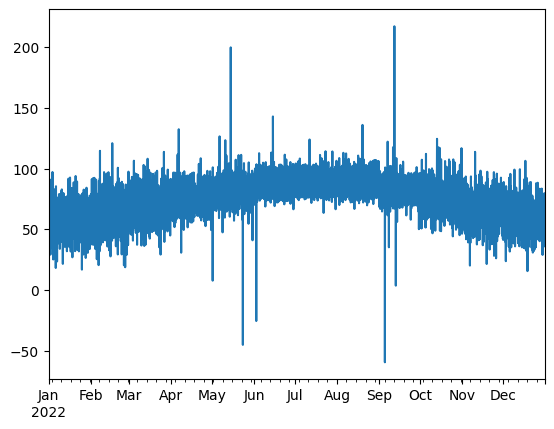

In [65]:
ser1.plot()

In [90]:
count1, rng1 = np.histogram(ser1.values, bins=282)
# count2, rng2 = np.histogram(ser.values, bins=94)

<AxesSubplot:xlabel='Dry-Bulb °F', ylabel='Frequency'>

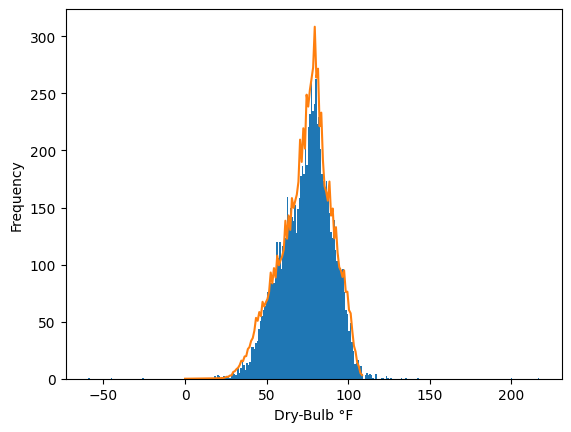

In [104]:
ser1.plot.hist(bins=300)
# ser.plot.hist(bins=94)
pd.DataFrame(actual.data).rolling(window=6).mean().fillna(0).set_index('Dry-Bulb °F').iloc[:, 0].plot()

In [103]:
pd.DataFrame(actual.data).rolling(window=2).mean()

,Dry-Bulb °F,Frequency hr,Cumulative Frequency %
0,NaN,NaN,NaN
1,18.5,0.274070,0.003650
2,19.5,0.274065,0.006779
3,20.5,0.228373,0.009386
4,21.5,0.182681,0.011471
...,...,...,...
89,106.5,7.931260,99.944747
90,107.5,2.817431,99.976910
91,108.5,1.387089,99.992744
92,109.5,0.407362,99.997394
